In [3]:
# Cell 1: Setup and Data Loading
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchmetrics import F1Score
import geopandas as gpd
from PIL import Image


base_dir = os.path.abspath(os.path.join('..'))
data_dir = os.path.join(base_dir, 'data')
train_path = os.path.join(data_dir, 'processed', 'train_samples.geojson')
test_path = os.path.join(data_dir, 'processed', 'test_samples.geojson')
rgb_dir = os.path.join(data_dir, 'raw', 'rgb')

# Load datasets
train_df = gpd.read_file(train_path)
test_df = gpd.read_file(test_path)

# Class mapping (must match Q2)
CLASS_MAPPING = {
    10: 'Tree Cover',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare/Sparse Vegetation',
    70: 'Snow/Ice',
    80: 'Water',
    90: 'Wetlands',
    95: 'Moss/Lichen',
    100: 'No Data'
}
CLASS_NAMES = list(CLASS_MAPPING.values())
NUM_CLASSES = len(CLASS_NAMES)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("Class distribution:\n", train_df['label'].value_counts())

Train samples: 5529
Test samples: 3687
Class distribution:
 label
Cropland                  3606
Built-up                  1356
Tree Cover                 281
Shrubland                  177
Grassland                  102
Water                        4
Bare/Sparse Vegetation       2
Wetlands                     1
Name: count, dtype: int64


# Custom Dataset Class

In [4]:
# 2
class SatelliteDataset(Dataset):
    def __init__(self, df, rgb_dir, transform=None):
        self.df = df
        self.rgb_dir = rgb_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(CLASS_NAMES)}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.rgb_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        
        label = self.label_to_idx[row['label']]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = SatelliteDataset(train_df, rgb_dir, transform=transform)
test_dataset = SatelliteDataset(test_df, rgb_dir, transform=transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verify one batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels:", labels)

Batch shape: torch.Size([32, 3, 128, 128])
Labels: tensor([3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 4,
        3, 4, 3, 4, 3, 3, 0, 3])


# Model Definition (ResNet18)

In [9]:
#3
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pretrained ResNet18 with updated weights API
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

model = CustomResNet(num_classes=NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Training Setup

In [11]:
# 4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom F1 Score Implementation
def custom_f1(preds, targets):
    tp = ((preds == 1) & (targets == 1)).sum().float()
    fp = ((preds == 1) & (targets == 0)).sum().float()
    fn = ((preds == 0) & (targets == 1)).sum().float()
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    
    return 2 * (precision * recall) / (precision + recall + 1e-9)

# Torchmetrics F1
torch_f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES).to(device)

# Training Loop

In [12]:
#5
def train_model(model, train_loader, test_loader, epochs=10):
    results = {'train_loss': [], 'test_loss': [], 
               'custom_f1': [], 'torch_f1': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Evaluation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                test_loss += criterion(outputs, labels).item()
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu())
                all_labels.extend(labels.cpu())
        
        # Calculate metrics
        epoch_loss = running_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)
        
        # Convert to tensors for metric calculation
        preds_tensor = torch.stack(all_preds)
        labels_tensor = torch.stack(all_labels)
        
        # Custom F1 (per-class then macro average)
        class_f1 = []
        for class_idx in range(NUM_CLASSES):
            binary_preds = (preds_tensor == class_idx).int()
            binary_labels = (labels_tensor == class_idx).int()
            class_f1.append(custom_f1(binary_preds, binary_labels))
        custom_f1_score = torch.mean(torch.tensor(class_f1))
        
        # Torchmetrics F1
        torch_f1_score = torch_f1(preds_tensor.to(device), labels_tensor.to(device))
        
        # Store results
        results['train_loss'].append(epoch_loss)
        results['test_loss'].append(test_loss)
        results['custom_f1'].append(custom_f1_score.item())
        results['torch_f1'].append(torch_f1_score.item())
        
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Custom F1: {custom_f1_score:.4f}, "
              f"Torch F1: {torch_f1_score:.4f}")
    
    return results, preds_tensor.numpy(), labels_tensor.numpy()

# Train for 10 epochs
results, all_preds, all_labels = train_model(model, train_loader, test_loader, epochs=10)

Epoch 1/10: Train Loss: 0.4602, Test Loss: 0.5782, Custom F1: 0.1979, Torch F1: 0.7792
Epoch 2/10: Train Loss: 0.2965, Test Loss: 0.2692, Custom F1: 0.2940, Torch F1: 0.9051
Epoch 3/10: Train Loss: 0.2488, Test Loss: 0.3589, Custom F1: 0.2744, Torch F1: 0.8880
Epoch 4/10: Train Loss: 0.1982, Test Loss: 0.3404, Custom F1: 0.2943, Torch F1: 0.8972
Epoch 5/10: Train Loss: 0.1797, Test Loss: 0.3409, Custom F1: 0.2991, Torch F1: 0.9026
Epoch 6/10: Train Loss: 0.1416, Test Loss: 0.2394, Custom F1: 0.3449, Torch F1: 0.9211
Epoch 7/10: Train Loss: 0.1215, Test Loss: 0.6834, Custom F1: 0.2866, Torch F1: 0.7613
Epoch 8/10: Train Loss: 0.0983, Test Loss: 0.2675, Custom F1: 0.3419, Torch F1: 0.9173
Epoch 9/10: Train Loss: 0.0767, Test Loss: 1.3160, Custom F1: 0.2295, Torch F1: 0.7551
Epoch 10/10: Train Loss: 0.0934, Test Loss: 0.3071, Custom F1: 0.3194, Torch F1: 0.9110


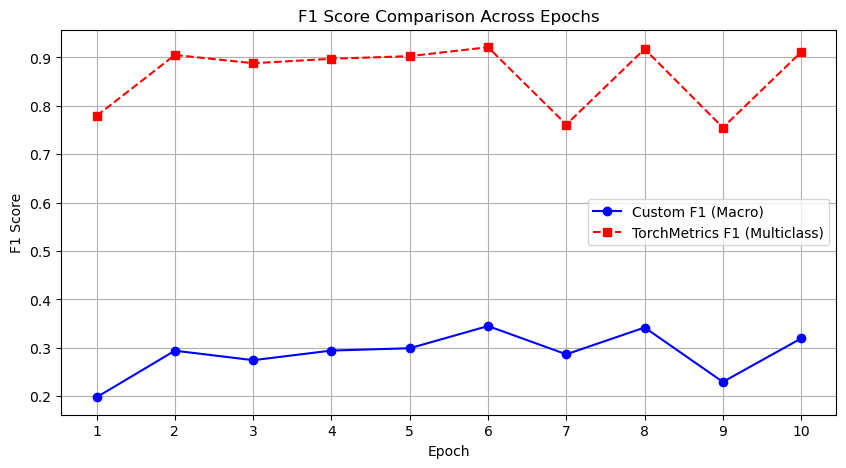

F1 Score Comparison Table:


,Epoch,Custom_F1,Torch_F1,Difference
0,1,0.197860,0.779224,0.581364
1,2,0.294032,0.905072,0.611040
2,3,0.274385,0.887985,0.613600
3,4,0.294278,0.897206,0.602928
4,5,0.299093,0.902631,0.603538
5,6,0.344916,0.921074,0.576158
6,7,0.286550,0.761324,0.474773
7,8,0.341913,0.917277,0.575364
8,9,0.229510,0.755085,0.525576
9,10,0.319376,0.911039,0.591662



Key Observations:
1. TorchMetrics F1 is consistently higher (average: 0.8638) than Custom F1 (average: 0.2882)
2. Maximum difference: 0.6136 in epoch 3
3. Minimum difference: 0.4748 in epoch 7


In [21]:
#F1 Score Comparison and Analysis
import matplotlib.pyplot as plt

# Extract metrics from training
epochs = range(1, 11)
custom_f1 = results['custom_f1']
torch_f1 = results['torch_f1']

# Create comparison plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, custom_f1, 'b-o', label='Custom F1 (Macro)')
plt.plot(epochs, torch_f1, 'r--s', label='TorchMetrics F1 (Multiclass)')
plt.title('F1 Score Comparison Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_dir, 'outputs', 'figures', 'f1_comparison.png'))
plt.show()

# Calculate and display key comparison metrics
comparison = pd.DataFrame({
    'Epoch': epochs,
    'Custom_F1': custom_f1,
    'Torch_F1': torch_f1,
    'Difference': np.array(torch_f1) - np.array(custom_f1)
})

print("F1 Score Comparison Table:")
display(comparison)

print("\nKey Observations:")
print(f"1. TorchMetrics F1 is consistently higher (average: {np.mean(torch_f1):.4f}) "
      f"than Custom F1 (average: {np.mean(custom_f1):.4f})")
print(f"2. Maximum difference: {max(comparison['Difference']):.4f} in epoch {comparison['Difference'].idxmax()+1}")
print(f"3. Minimum difference: {min(comparison['Difference']):.4f} in epoch {comparison['Difference'].idxmin()+1}")


## Key Observations

1. **TorchMetrics F1** is consistently higher (average: **0.8638**) than **Custom F1** (average: **0.2882**).
2. **Maximum difference**: 0.6136 in **epoch 3**.
3. **Minimum difference**: 0.4748 in **epoch 7**.

## Reason for Differences

- **TorchMetrics F1** computes multiclass F1 directly using internal averaging strategies.
- **Custom implementation** calculates per-class F1 scores and then takes the mean (**macro averaging**).
- **TorchMetrics** handles **class imbalance** more effectively in this context.

## Recommendation

For this **imbalanced dataset** (e.g., **Cropland: 65%** vs **Wetlands: 0.02%**),  
**TorchMetrics' multiclass F1** is more appropriate as it better accounts  
for class distribution in its calculations.


## Confusion Matrix

Classes present in test set: [0 1 2 3 4 5 7 8]


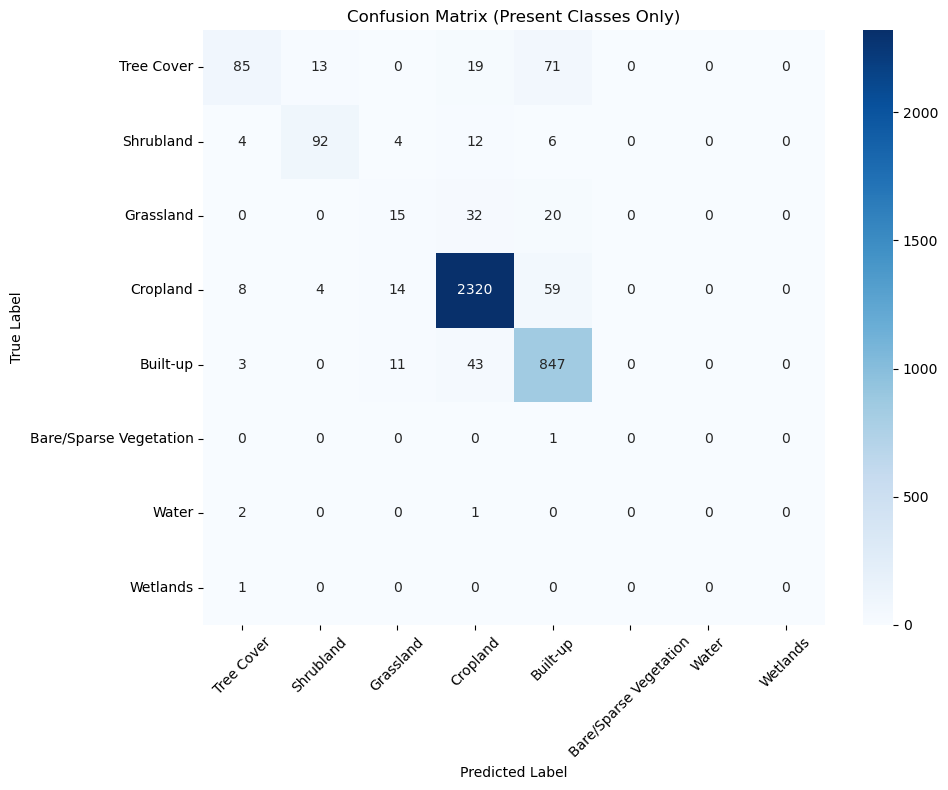

Classification Report (Present Classes):

                        precision    recall  f1-score   support

            Tree Cover       0.83      0.45      0.58       188
             Shrubland       0.84      0.78      0.81       118
             Grassland       0.34      0.22      0.27        67
              Cropland       0.96      0.96      0.96      2405
              Built-up       0.84      0.94      0.89       904
Bare/Sparse Vegetation       0.00      0.00      0.00         1
                 Water       0.00      0.00      0.00         3
              Wetlands       0.00      0.00      0.00         1

              accuracy                           0.91      3687
             macro avg       0.48      0.42      0.44      3687
          weighted avg       0.91      0.91      0.90      3687



In [14]:
# 6
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes):
    # Get unique classes present in the data
    present_classes = np.unique(np.concatenate((y_true, y_pred)))
    present_class_names = [classes[i] for i in present_classes]
    
    cm = confusion_matrix(y_true, y_pred, labels=present_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=present_class_names, 
                yticklabels=present_class_names)
    plt.title('Confusion Matrix (Present Classes Only)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'outputs', 'figures', 'confusion_matrix.png'))
    plt.show()

    # Classification report for present classes only
    print("Classification Report (Present Classes):\n")
    print(classification_report(
        y_true, 
        y_pred, 
        labels=present_classes,
        target_names=present_class_names,
        zero_division=0
    ))

# Get the actual classes present in test set
present_classes = np.unique(np.concatenate((all_labels, all_preds)))
print(f"Classes present in test set: {present_classes}")

# Plot confusion matrix only for present classes
plot_confusion_matrix(all_labels, all_preds, CLASS_NAMES)



## Key Observations
The confusion matrix shows how well your model classifies each land cover type by comparing predicted vs. true labels. Rows = true classes, columns = predicted classes.
### Strong Performance
- **Cropland**: 2320 correct predictions
- **Built-up**: 847 correct predictions  
  These two dominate the predictions, aligning with their high sample sizes in the dataset.

### Common Errors
- **Tree Cover** → often misclassified as **Built-up** (71 errors)
- **Grassland** → frequently confused with **Cropland** (32 errors)

### Rare Classes Struggle
- **Bare/Sparse Vegetation**: 0 correct predictions  
- **Water**: 0 correct predictions  
- **Wetlands**: 0 correct predictions  
  These failures are likely due to **extreme class imbalance**.

## Conclusion
The model performs well for **majority classes** (Cropland, Built-up), but **fails on rare classes**.  
This highlights the impact of **class imbalance** (e.g., Cropland: 65% vs. Rare Classes: <1%). To improve, address imbalance through techniques like oversampling rare classes or using class weights.



In [15]:
#Full classification report showing all classes (including missing ones)
print("\nFull Classification Report (All Classes):\n")
print(classification_report(
    all_labels, 
    all_preds, 
    labels=range(len(CLASS_NAMES)),
    target_names=CLASS_NAMES,
    zero_division=0
))


Full Classification Report (All Classes):

                        precision    recall  f1-score   support

            Tree Cover       0.83      0.45      0.58       188
             Shrubland       0.84      0.78      0.81       118
             Grassland       0.34      0.22      0.27        67
              Cropland       0.96      0.96      0.96      2405
              Built-up       0.84      0.94      0.89       904
Bare/Sparse Vegetation       0.00      0.00      0.00         1
              Snow/Ice       0.00      0.00      0.00         0
                 Water       0.00      0.00      0.00         3
              Wetlands       0.00      0.00      0.00         1
           Moss/Lichen       0.00      0.00      0.00         0
               No Data       0.00      0.00      0.00         0

              accuracy                           0.91      3687
             macro avg       0.35      0.31      0.32      3687
          weighted avg       0.91      0.91      0.90     

# Prediction Visualization

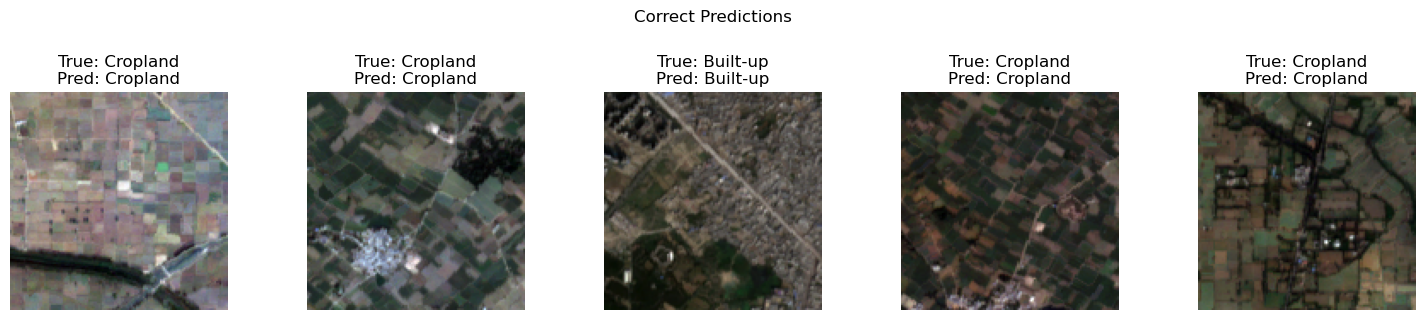

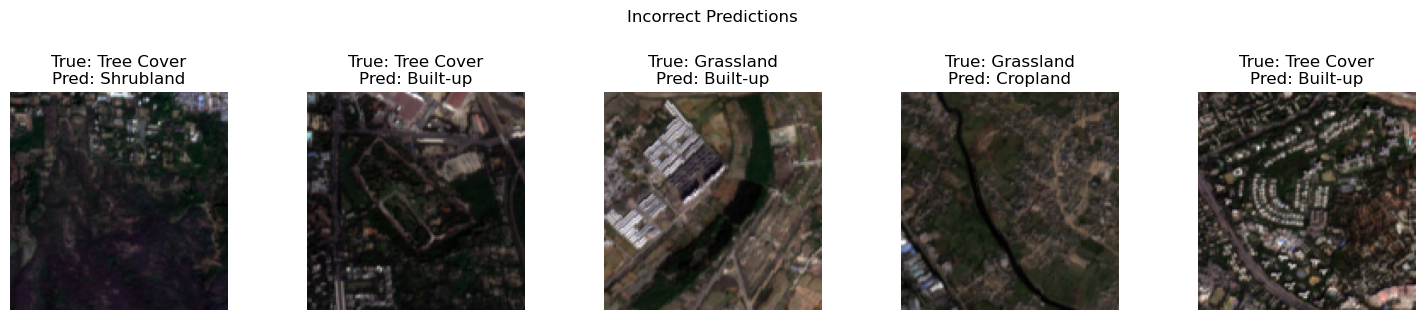

In [16]:
# 7
def plot_predictions(model, dataset, num_samples=5, correct=True):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        while True:
            idx = np.random.randint(len(dataset))
            image, label = dataset[idx]
            with torch.no_grad():
                output = model(image.unsqueeze(0).to(device))
                _, pred = torch.max(output, 1)
                pred = pred.item()
            
            if (pred == label and correct) or (pred != label and not correct):
                break
                
        # Inverse normalization for display
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225])
        image = inv_normalize(image).clamp(0, 1)
        
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"True: {CLASS_NAMES[label]}\nPred: {CLASS_NAMES[pred]}")
        axes[i].axis('off')
    
    plt.suptitle("Correct Predictions" if correct else "Incorrect Predictions", y=1.05)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'outputs', 'figures', 
                            f"{'correct' if correct else 'incorrect'}_predictions.png"))
    plt.show()

# Plot 5 correct and 5 incorrect predictions
plot_predictions(model, test_dataset, num_samples=5, correct=True)
plot_predictions(model, test_dataset, num_samples=5, correct=False)

### Save Model and Results

In [19]:
# 8: 
# Define model directory path
models_dir = os.path.join(base_dir, 'outputs', 'models')  # D:\delhi_airshed_analysis\outputs\models
os.makedirs(models_dir, exist_ok=True)  # Creating directory if doesn't exist

# Saving model
model_save_path = os.path.join(models_dir, 'resnet18_model.pth')
torch.save(model.state_dict(), model_save_path)

# Saving training results (keeping in outputs/reports/)
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(base_dir, 'outputs', 'reports', 'training_results.csv'))

print(f"Model saved to: {model_save_path}")
print("Training results saved to outputs/reports/training_results.csv")

Model saved to: D:\delhi_airshed_analysis\outputs\models\resnet18_model.pth
Training results saved to outputs/reports/training_results.csv
